In [1]:

from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches



In [2]:
#set weight
w1 = np.array([np.ones(1)*1, np.ones(1)*1,np.ones(1)*-1])
w2 = np.array([np.ones(1)*2, np.ones(1)*1,np.ones(1)*1])
w3 = np.array([np.ones(1)*-1, np.ones(1)*2,np.ones(1)*-3])
w4 = np.array([np.ones(1)*1, np.ones(1)*2,np.ones(1)*3])
w5 = np.array([np.ones(1)*1, np.ones(1)*1,np.ones(1)*3])
w1 = np.hstack(w1)
w2 = np.hstack(w2)
w3 = np.hstack(w3)
w4 = np.hstack(w4)
w5 = np.hstack(w5)
weight = np.array((w1,w2,w3,w4,w5))
weight = weight.transpose()



In [3]:
# create a dataset with 2 clusters and 2 features
raw_data1=np.array([np.ones(1)*1,np.ones(1)*2,np.ones(1)*-1])
raw_data2=np.array([np.ones(1)*-1,np.ones(1)*3,np.ones(1)*-2])
raw_data=np.hstack((raw_data1, raw_data2))
raw_data=(raw_data + weight*0.2)




ValueError: operands could not be broadcast together with shapes (3,2) (3,5) 

In [4]:
# create map dimension
network_dimensions = np.array([5, 5])
n_iterations = 1000
init_learning_rate = 0.5

normalise_data = True



In [5]:
# if True, assume all data on common scale
# if False, normalise to [0 1] range along each column
normalise_by_column = False

# establish variables based on data
m = raw_data.shape[0]
n = raw_data.shape[1]

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

data = raw_data
# check if data needs to be normalised
if normalise_data:
    if normalise_by_column:
        # normalise along each column
        col_maxes = raw_data.max(axis=0)
        data = raw_data / col_maxes[np.newaxis, :]
    else:
        # normalise entire dataset
        data = raw_data / data.max()

# setup random weights between 0 and 1
# weight matrix needs to be one m-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))




In [6]:
def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max    
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)




In [7]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)


def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)


def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

for i in range(n_iterations):
    #print('Iteration %d' % i)
    
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = 1
    l = 1
    
    # now we know the BMU, update its weight vector to move closer to input
    # and move its neighbours in 2-D space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, 3)




ValueError: RGBA values should be within 0-1 range

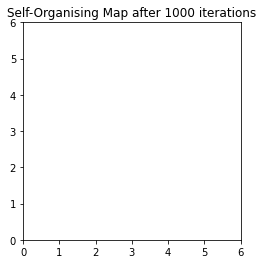

In [8]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# The Plot can be seen asa compression of the 3000x3 dataset into a 5x5x3 map
# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()

